# Sync this blink

We did record a movie of a LED blinking. If the synchronisation is correct, we should be able to know for each frame if the LED is on or off.

Let's check that


## Load the data

We have an `avi` video, a `csv` of timestamp and `dat` file with the analog
signal recording of the sync triggers. Let's load that.

### [optional] mount google drive folder in the collab

If you are using this collab and have your data in your google drive folder, we can mount the folder directly. If you analyse your data locally, ignore this step.
Click on the folder symbol on the left of this window. In the "Files" pane that appears click on "Mount drive". Then in the file explorer, locate your data and copy the path.

This can also be done in the notebook it self by running the following cell:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the timestamp and frame index

In [ ]:
# Here put the path to your files
path2avi = "/content/drive/MyDrive/TENSS/TENSS_2024/sync_practicals/example_recording/Blinkage.avi"
path2csv = "/content/drive/MyDrive/TENSS/TENSS_2024/sync_practicals/example_recording/Blinkage_timestamps.csv"

In [ ]:
import pandas as pd

timestamps = pd.read_csv(path2csv)
timestamps.head()

,camera_timestamp,frame_id,computer_timestamp
0,2464305647704,2265,2024-06-10T15:08:57.6185728+03:00
1,2464355649056,2266,2024-06-10T15:08:57.6226432+03:00
2,2464405649536,2267,2024-06-10T15:08:57.6694016+03:00
3,2464455651240,2268,2024-06-10T15:08:57.7193088+03:00
4,2464505652456,2269,2024-06-10T15:08:57.7690112+03:00


### Load the video

Videos can be big. We will not load the whole video but just use open the file to count the number of frames and load one example frame.

We will use [`opencv`](https://opencv.org/) it's a very comprehensive and efficient library for video handling, but not the most user friendly. Google is your friend.

In [ ]:
import cv2

# Open a file handle to read the movie
cap = cv2.VideoCapture(path2avi)
# Read the number of frame.
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# If you are curious, lot of other video properties can be accessed this way
# https://docs.opencv.org/4.x/d4/d15/group__videoio__flags__base.html#gaeb8dd9c89c10a5c63c139bf7c4f5704d

# load the first frame
# cap.read() will return not only the frame but also a boolean value if the
# frame is availlable or not
success, first_frame = cap.read()
assert success, "We failed to read the first frame!"

# once you are done with your video, release the file handle to allow other
# processes to access it. Not really important here in a collab
cap.release()
print(f"Video has {length} frames of shape {first_frame.shape}")

if length == len(timestamps):
  print("We have a timestamp for each frame. Bonsai did well")
else:
  raise ValueError(f'{length} frames but {len(timestamps)} timestamps. ' +
                   ' It is impossible. Bonsai must do better')

Video has 665 frames of shape (1080, 1440, 3)
We have a timestamp for each frame. Bonsai did well


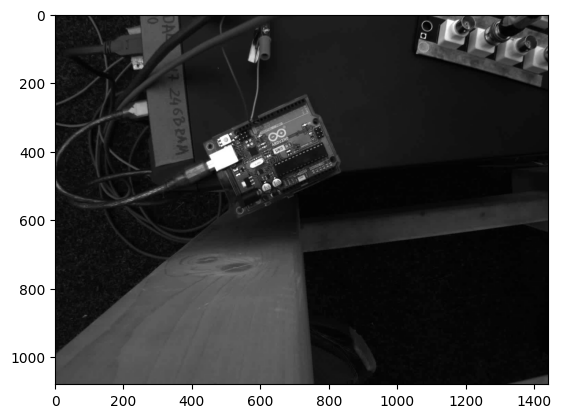

In [ ]:
# Display the first frame
import matplotlib.pyplot as plt

_ = plt.imshow(first_frame)

## Look for frame drop

Cameras are usually very good at sending data, our computer is not always so good at getting it. Sometimes, when the data comes faster than it can be written, a frame is dropped (or buffered frames accumulate in RAM until the computer crashes).

Let's check here is we have frame dropped

In [ ]:
first_frame_index = timestamps.frame_id.iloc[0]
last_frame_index = timestamps.frame_id.iloc[-1]
print(f"First frame: {first_frame_index}")
print(f"Last frame: {last_frame_index}")
n_frame_acquired = last_frame_index - first_frame_index + 1
# +1 as diff is the number of intervals.
# If indices are 1 and 2, diff is 1, number of frames 2

print(f"Number of frame between the first and the last: {n_frame_acquired}")
print(f"Number of frames in the video file: {length}")
print(f"{n_frame_acquired - length} frame(s) dropped")

First frame: 2265
Last frame: 2929
Number of frame between the first and the last: 665
Number of frames in the video file: 665
0 frame(s) dropped


Hopefully this should be 0. If it isn't we'll have to handle it later.

## Load the analog data

THE LONG VERSION:

There are many ways to load the `dat` file and the openephys data. For now we will do it with low level function. Once you have electrophysiology data, consider using the openephys helper package,  [open-ephys-python-tools](https://github.com/open-ephys/open-ephys-python-tools).

A `dat` file is just a pure binary file. It will be a sequence of 0s and 1s. First we need to know how many bits are used by each sample (it's 16). Then we need to know if which order are all the samples written. In this case, it will contain the value for the first sample of the first channel, `S1C1`. Then, the value for the second channel, etc... until we run out of channels. Then the value for the second sample point will be written, so the file looks like that:
`S1C1,S1C2,S1C3...S2C1,S2C2,...`.

To read the file, we therefore need to know how many channels we have, if you saved only the analog inputs, it should be 8.

In [ ]:
# Path to the folder containing the dat and npy files
ephys_folder = "/content/drive/MyDrive/TENSS/TENSS_2024/sync_practicals/example_recording/Blinkage/Record Node 101/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data"
chan_number = 8

In [ ]:
import numpy as np

analog_data = np.fromfile(ephys_folder + "/continuous.dat", dtype="int16")
print(f"The file contains {len(analog_data)} samples")
analog_data = analog_data.reshape((-1, chan_number))
print(f"Reshaping: {analog_data.shape}")

The file contains 15255552 samples
Reshaping: (1906944, 8)


## Find the sync pulses

We recorded the pulse in an analog channel, mostly to be able to see the shape of the data and ensure you're not just recording noise.
That means that we need to make it binary ourselves and detect when there are pulse.

First look at the channel which contains the frame trigger, it depends where you connected the BNC.

In [ ]:
channel_trigger = 0

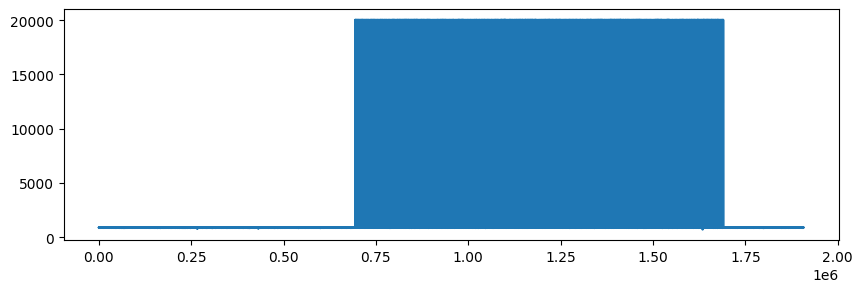

In [ ]:
# Check that there are pulses
fig = plt.figure(figsize=(10, 3))
sync_data = analog_data[:, channel_trigger]
plt.plot(sync_data)

Threshold guessed at 10027.5


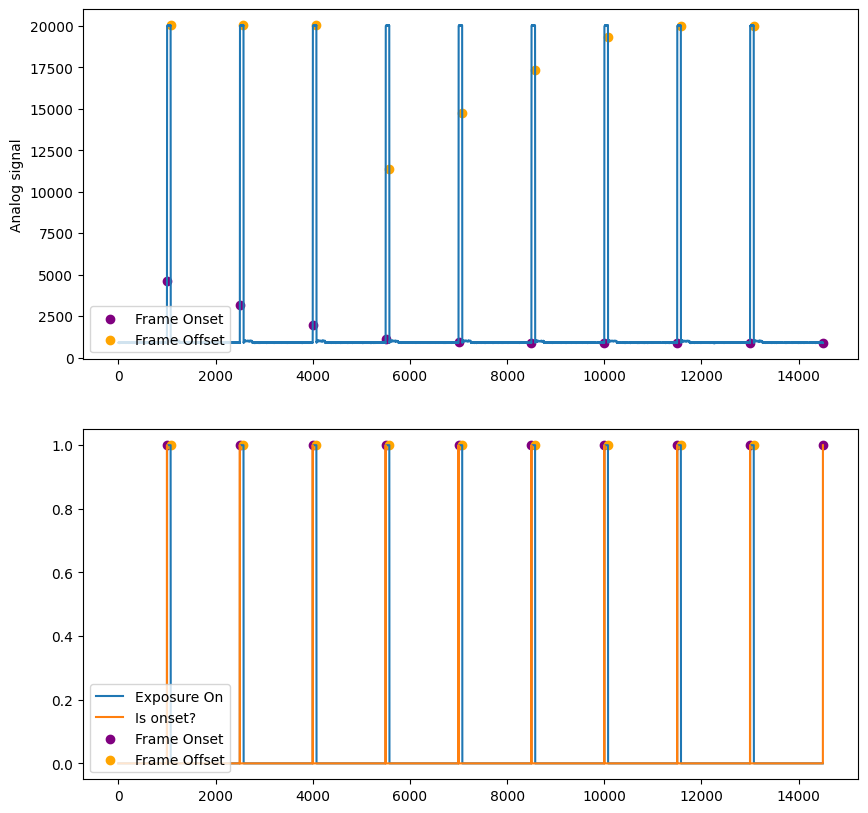

In [ ]:
# To detect the sync pulse we will first make the trace binary
threshold = sync_data.max()/ 2  # cut at half the high value.
print(f"Threshold guessed at {threshold}")
# We don't use max in case there are a couple of big artefacts
exposure_on = sync_data > threshold  # exposure_on is boolean, True or False
# we will make it integer because we want to have -1, 0, 1.
is_pulse_onset = np.diff(exposure_on.astype("int")) == 1
is_pulse_offset = np.diff(exposure_on.astype("int")) == -1

frame_start_index = np.where(is_pulse_onset)[0]
frame_stop_index = np.where(is_pulse_offset)[0]

# For sanity check, just plot the first N frames pulses
nframes2plot = 10
# add a bit of baseline and 1 sample to include the last frame onset
xlims = frame_start_index[0] - 1000, frame_start_index[nframes2plot - 1] + 1

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
# plot the continuous signals
axes[0].plot(sync_data[xlims[0] : xlims[1]])
axes[1].plot(exposure_on[xlims[0] : xlims[1]], label="Exposure On")
axes[1].plot(is_pulse_onset[xlims[0] : xlims[1]], label="Is onset?")

# add the detected frame onset/offsets
labels = ("Onset", "Offset")
colors = ("purple", 'orange')
for i, ind in enumerate([frame_start_index, frame_stop_index]):
  if labels[i] == 'Offset':
    # the last frame offset will be out of the plot, don't add it
    nframes2plot -= 1
  axes[0].scatter(
    ind[:nframes2plot] - xlims[0],
    sync_data[ind[:nframes2plot]],
    label=f"Frame {labels[i]}",
    color=colors[i],
  )
  axes[1].scatter(
      ind[:nframes2plot] - xlims[0],
      np.ones(nframes2plot),
    label=f"Frame {labels[i]}",
    color=colors[i],
  )

# Label
axes[0].set_ylabel("Analog signal")
axes[0].legend(loc="lower left")
axes[1].legend(loc="lower left")

## Synchronise

Now we have all we need to synchronise. We should have one pulse by frame taken by the camera, and maybe less saved frame if some got dropped.

Check that, because if we don't, we need to fix the hardware.

In [ ]:
n_pulses = len(frame_start_index)
print(f"The camera took {n_frame_acquired} frames and we recorded {n_pulses}")
if n_frame_acquired == n_pulses:
    print("We are happy. Life it beautiful")
else:
    raise ValueError("I cannot sync that! Did you start the recording properly?")

The camera took 665 frames and we recorded 665
We are happy. Life it beautiful


Now we want to find which pulse corresponds to which frame.
If there are no dropped frames, everything is very simple, otherwise, we need to look at frame IDs. Let's do that

In [ ]:
frame_id = timestamps.frame_id.values
# the first pulse must be the first frame, since we started the camera after
# the OE recording
frame_sync_pulse_index = frame_id - frame_id[0]

Finally we can convert from frame index to ephys samples and the converse. We will make tiny functions to make it easy to re-use

In [ ]:
import warnings

def frame2oe(frame_index):
  """Return the openephys sample corresponding to frame onset

  Args:
    frame_index (int): index of the frame in the avi movie

  Return:
    onset (int): index of the first sample of the frame in the OE recording
    offset (int): index of the last sample of the frame in the OE recording
  """
  # find the correct sync pulse:
  pulse_index = frame_sync_pulse_index[frame_index]
  # and where that pulse was in the recording
  oe_on = frame_start_index[pulse_index]
  oe_off = frame_stop_index[pulse_index]
  return oe_on, oe_off

def oe2frame(oe_sample):
  """Return the index of the last frame acquired before the OE sample

  Args:
    oe_sample (int): index in the OE recording

  Return:
    frame_index (int): last frame before the OE sample
  """

  if oe_sample < frame_start_index[0]:
    warnings.warn("Sample is before video start")
  first_frame_aft = frame_start_index.searchsorted(oe_sample)
  if first_frame_aft == len(frame_start_index):
    raise ValueError("Sample is after video end")
  return max(first_frame_aft - 1, 0) # clip at 0




# Check if it works!


## Look for the led in the video

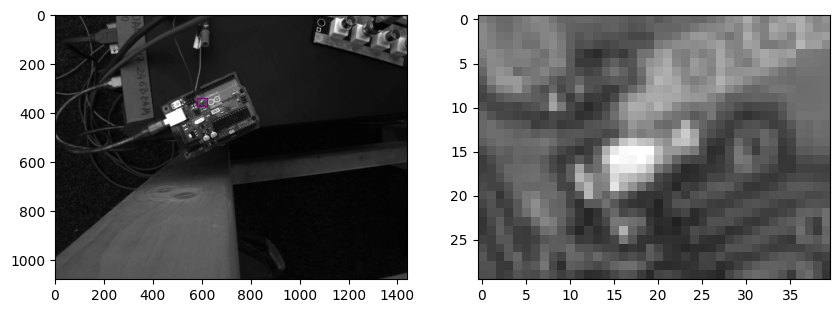

In [ ]:
# Change the cropping to cut only the LED
ledx = [580,620]
ledy = [340,370]

fig, axes = plt.subplots(1,2,figsize=(10,5))
_ = axes[0].imshow(first_frame)
rect = plt.Rectangle(xy=[ledx[0], ledy[0]], width=np.diff(ledx)[0], height=np.diff(ledy)[0], facecolor='none', edgecolor='purple')
axes[0].add_artist(rect)
_ = axes[1].imshow(first_frame[ledy[0]:ledy[1], ledx[0]:ledx[1]])


## Find LED in OpenEphys

You should have saved the TTL in one OE channel. Let's look for that.





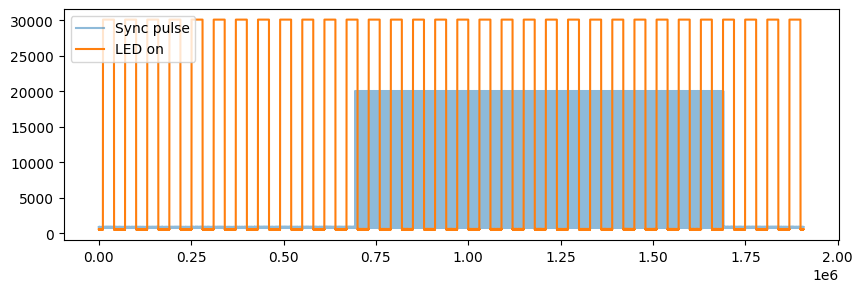

In [ ]:
led_pulse_channel = 2
# Check that there are pulses
fig = plt.figure(figsize=(10, 3))
blink_data = analog_data[:, led_pulse_channel]
plt.plot(sync_data, label='Sync pulse', alpha=0.5)
plt.plot(blink_data, label='LED on')
plt.legend(loc='upper left')


Let's zoom in on one sample where the led is turning ON

(789000.0, 792500.0)

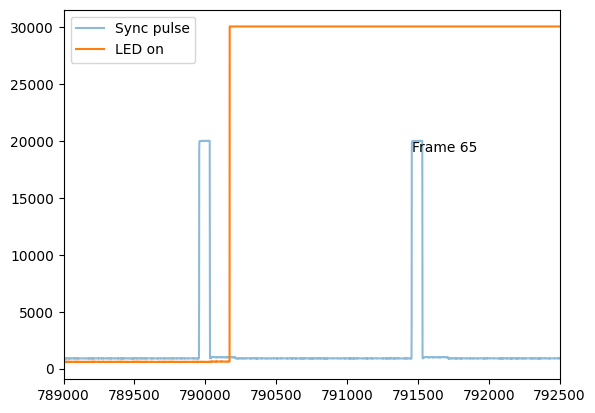

In [ ]:
# Change that
xlim = [789000, 792500]


# Find the last frame before xlim[1]
frame_index = oe2frame(xlim[1])
# and the corresponding frame onset/offset in OE samples
oe_on, oe_off = frame2oe(frame_index)

xlim = np.array(xlim).astype(int)
plt.plot(sync_data, label='Sync pulse', alpha=0.5)
plt.plot(blink_data, label='LED on')
plt.legend(loc='upper left')
# add one to oe_on and the sync pulse takes a couple of samples to reach
# the high state
plt.text(oe_on, sync_data[oe_on+1], f'Frame {frame_index}')
plt.xlim(xlim)

Now let's look at a frame where the led should be On and one where it should be off

Text(0.5, 1.0, 'Frame 65')

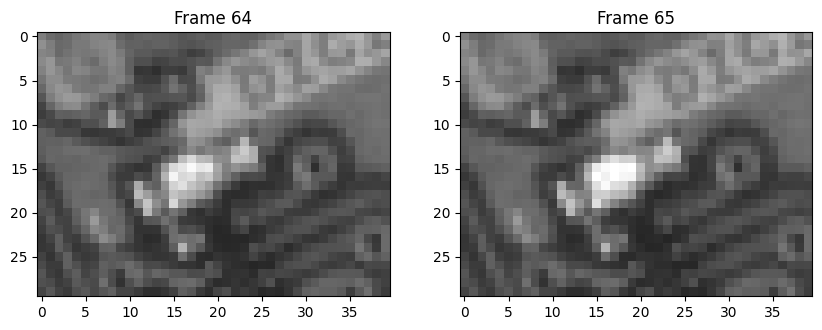

In [ ]:
cap = cv2.VideoCapture(path2avi)
# set the video to 1 frames before the pulse
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index-1)
# read the frame before the pulse
res, frame_bef = cap.read()
# read the frame after the pulse
res, frame_aft = cap.read()

fig, axes = plt.subplots(1,2, figsize=(10,5))
vmax = frame_bef[ledy[0]:ledy[1], ledx[0]:ledx[1]].max()
vmin = frame_bef[ledy[0]:ledy[1], ledx[0]:ledx[1]].min()
axes[0].imshow(frame_bef[ledy[0]:ledy[1], ledx[0]:ledx[1]], vmax=vmax, vmin=vmin)
axes[0].set_title(f'Frame {frame_index-1}')
axes[1].imshow(frame_aft[ledy[0]:ledy[1], ledx[0]:ledx[1]], vmax=vmax, vmin=vmin)
axes[1].set_title(f'Frame {frame_index}')



We can also compare the brightness to the LED pulse

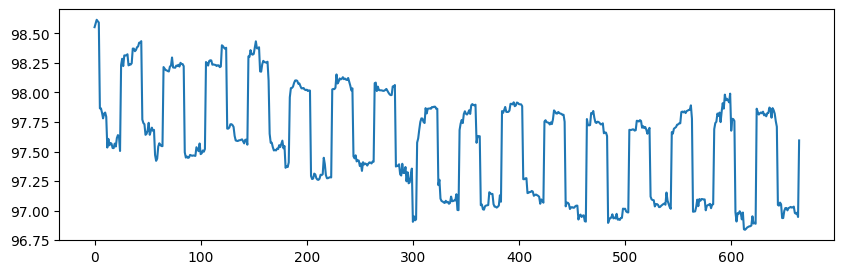

In [ ]:
# Open a file handle to read the movie
cap = cv2.VideoCapture(path2avi)
brightness  = np.zeros(length)  # that's the number of frames

success = True
frame_id = 0
while success:
  success, frame = cap.read()
  if success:
    brightness[frame_id] = frame[ledy[0]:ledy[1], ledx[0]:ledx[1]].mean()
    frame_id += 1
cap.release()

plt.figure(figsize=(10,3))
plt.plot(brightness)

Text(0, 0.5, 'Brightness')

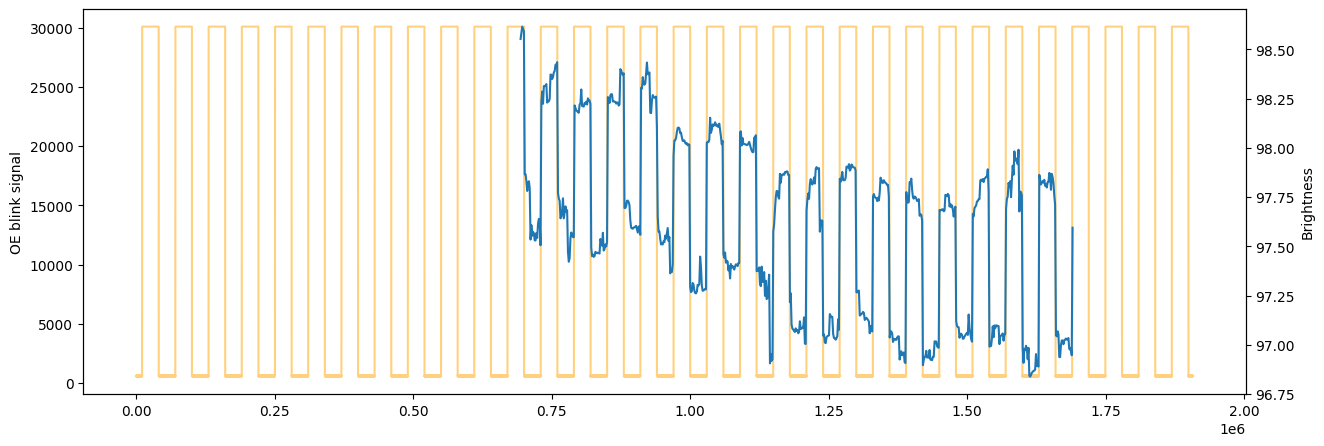

In [ ]:
# Find the oe sample of each frame start
oe_onset, oe_offset = frame2oe(np.arange(length))


plt.figure(figsize=(15,5))
plt.plot(blink_data, color='orange', alpha=0.5)
plt.ylabel('OE blink signal')
plt.twinx()
plt.plot(oe_onset, brightness)
plt.ylabel('Brightness')

In [ ]:
print('Done!')

Done!
